# Linear model on MNIST

In [1]:
using Knet, Plots, Statistics, LinearAlgebra, Base.Iterators, Random, StatsBase
ENV["COLUMNS"] = 80
ARRAY = KnetArray{Float64}
XSIZE=49   # input dimension
YSIZE=10    # output dimension
BATCHSIZE=10 # minibatch size
LAMBDA=1e-2 # regularization parameter
#LAMBDA=1e-10
#LR=1e-1     # learning rate
LR=1e-2     # learning rate
#MITER=10^4  # iterations for finding minimum
MITER=10^5  # iterations for finding minimum
DITER=10^5  # iterations for diffusion tensor
CITER=5*10^7 # iterations for covariance trajectory 
CFREQ=10^2  # keep every CFREQ points on trajectory

100

# Define regularized linear model with softmax loss

In [2]:
pred(w,x) = reshape(w,YSIZE,XSIZE) * reshape(x,XSIZE,:)
loss(w,x,y;λ=LAMBDA) = nll(pred(w,x), y) + (λ/2) * sum(abs2,w)

loss (generic function with 1 method)

# Load MNIST data

In [3]:
xtrn,ytrn,xtst,ytst = Knet.load("mnist7x7.jld2","xtrn","ytrn","xtst","ytst")
atrn,atst = ARRAY(xtrn), ARRAY(xtst) # GPU copies for batch training
println.(summary.((xtrn,ytrn,xtst,ytst,atrn,atst)));

49×60000 Array{Float32,2}
60000-element Array{UInt8,1}
49×10000 Array{Float32,2}
10000-element Array{UInt8,1}
49×60000 KnetArray{Float64,2}
49×10000 KnetArray{Float64,2}


# Minibatch data

In [4]:
# Minibatching for SGD-I, i.e. with replacement. Knet.minibatch can't do this, we define new struct
struct MB; x; y; n; end
Base.Iterators.IteratorSize(::Type{MB}) = Base.IsInfinite() # need this for collect to work
Base.iterate(d::MB, s...)=(r = rand(1:length(d.y),d.n); ((ARRAY(mat(d.x)[:,r]), d.y[r]), true))
dtrn = MB(xtrn, ytrn, BATCHSIZE)
println.(summary.(first(dtrn)));

49×10 KnetArray{Float64,2}
10-element Array{UInt8,1}


# Find minimum

In [5]:
LAMBDA,MITER,BATCHSIZE

(0.01, 100000, 10)

In [6]:
# Find minimum without minibatching
# ~50 iters/sec, converges in 3 mins to 
# 0.267218 for LAMBDA=1e-4 (err=0.25, reg=0.02)
# 0.344490 for LAMBDA=1e-3 (err=0.29, reg=0.05)
# 0.558482 for LAMBDA=1e-2 (err=0.41, reg=0.15)
wminfile = "mnist7x7_wmin-$LAMBDA-$MITER.jld2"
if !isfile(wminfile)
    wmin = Param(ARRAY(zeros(XSIZE*YSIZE)))
    args = repeat([(wmin,atrn,ytrn)],MITER)
    Knet.gc()
    losses = collect(progress(adam(loss,args)))
    Knet.save(wminfile, "wmin", wmin, "losses", losses)
else
    wmin, losses = Knet.load(wminfile, "wmin", "losses");
end
@show summary(wmin)
losses[end-4:end]'

summary(wmin) = "490-element Param{KnetArray{Float64,1}}"


1×5 Adjoint{Float64,Array{Float64,1}}:
 1.10636  1.10636  1.10636  1.10636  1.10636

In [7]:
Nweights = length(wmin)

490

In [8]:
println.((
(loss(wmin,atrn,ytrn),nll(pred(wmin,atrn),ytrn),(LAMBDA/2)*sum(abs2,wmin)),
(loss(wmin,atst,ytst),nll(pred(wmin,atst),ytst),(LAMBDA/2)*sum(abs2,wmin)),
(accuracy(pred(wmin,atrn),ytrn),accuracy(pred(wmin,atst),ytst))));

(1.1063619979685433, 0.7980894501114997, 0.30827254785704356)
(1.0757875087606124, 0.7675149609035689, 0.30827254785704356)
(0.83995, 0.8496)


# Hessian of loss around minimum

In [9]:
function hessian(loss,w,x,y)
    ∇loss = grad(loss)
    ∇lossi(w,x,y,i) = ∇loss(w,x,y)[i]
    ∇∇lossi = grad(∇lossi)
    w = value(w)
    n = length(w)
    h = similar(w,n,n)
    for i in progress(1:n)
        h[:,i] .= vec(∇∇lossi(w,x,y,i))
    end
    return h
end

hessian (generic function with 1 method)

In [10]:
# Compute hessian: ~5 mins
hessfile = "mnist7x7_hess-$LAMBDA.jld2"
if !isfile(hessfile)
    Knet.gc()
    hmin = hessian(loss,wmin,atrn,ytrn)
    Knet.save(hessfile,"h",hmin)
else
    hmin = Knet.load(hessfile,"h")
end
println.((summary(hmin),extrema(Array(hmin)),norm(hmin),norm(hmin-hmin')));

490×490 KnetArray{Float64,2}
(-0.010662502848995954, 0.04945868611768217)
1.0786819988554515
9.024316869200822e-17


# Eigenvalues of the Hessian

In [11]:
heigfile = "mnist7x7_nosym_heig-$LAMBDA.jld2"
H = Array(hmin)
if !isfile(heigfile)
#    @time eigenH = eigen(Symmetric(H)) # ~53s
    @time eigenH = eigen(H) # ~53s
    Knet.save(heigfile,"eigenH",eigenH)
else
    eigenH = Knet.load(heigfile,"eigenH")
end
eigenH.values'

1×490 Adjoint{Float64,Array{Float64,1}}:
 0.453571  0.412518  0.397331  …  0.01  0.01  0.01  0.01  0.01  0.01

In [12]:
summarystats(real.(eigenH.values)) |> dump
#scatter(real.(eigenH.values),xaxis=:log10,yaxis=:log10)

StatsBase.SummaryStats{Float64}
  mean: Float64 0.021086560786777543
  min: Float64 0.00999999999999996
  q25: Float64 0.011061495022404897
  median: Float64 0.013148749944676113
  q75: Float64 0.01688013927520136
  max: Float64 0.453570717137507
  nobs: Int64 490
  nmiss: Int64 0


# Diffusion Tensor

In [13]:
function diffusiontensor(loss,w,x,y;iters=DITER,lr=LR,batchsize=BATCHSIZE)
    ∇loss = grad(loss)
    grad0 = Array(∇loss(w, ARRAY(x), y))
    data = MB(x,y,batchsize)
    grads = zeros(length(w), iters)
    for (i,d) in progress(enumerate(take(data,iters)))
        grads[:,i] .= Array(∇loss(w,d...))
    end
    prefac = (lr^2)/(2iters)
    grads = grad0 .- grads
    @time v = prefac * (grads * grads')
    return v
end

diffusiontensor (generic function with 1 method)

In [14]:
LAMBDA,LR,BATCHSIZE,DITER

(0.01, 0.01, 10, 100000)

In [15]:
dtfile = "mnist7x7_dt-$LAMBDA-$LR-$BATCHSIZE-$DITER.jld2"
if !isfile(dtfile)
    Knet.gc()
    D = diffusiontensor(loss,wmin,xtrn,ytrn) # ~700 iters/sec
    Knet.save(dtfile,"D",D)
else
    D = Knet.load(dtfile,"D")
end
summarystats(vec(D)) |> dump

StatsBase.SummaryStats{Float64}
  mean: Float64 -7.207254649983065e-27
  min: Float64 -5.337337084114389e-8
  q25: Float64 -1.0581145583097081e-9
  median: Float64 -1.639171474992791e-10
  q75: Float64 2.1270713229026452e-11
  max: Float64 1.4054070332907275e-7
  nobs: Int64 240100
  nmiss: Int64 0


In [16]:
eigenD = eigen(D);

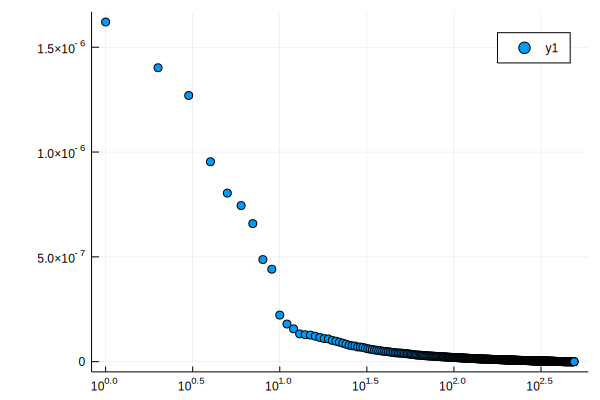

In [17]:
scatter(reverse(eigenD.values),xaxis=:log10)#,yaxis=:log10)

# Record trajectory with SGD starting at minimum

In [18]:
LAMBDA,LR,BATCHSIZE,CITER,CFREQ

(0.01, 0.01, 10, 50000000, 100)

In [19]:
# Trajectory of w starting from wmin recorded after each update: 
# ~1000 updates/sec, ~16 secs total
trajfile = "mnist7x7_traj-$LAMBDA-$LR-$BATCHSIZE-$CITER-$CFREQ.jld2"
snapshotfreq = div(CITER,5)
if !isfile(trajfile)
    w = Param(ARRAY(value(wmin)))
    data = MB(xtrn,ytrn,BATCHSIZE)
    d = take(data,CITER)
    W = zeros(eltype(w),length(w),div(CITER,CFREQ))
    f(x,y) = loss(w,x,y)
    Knet.gc()
    i = 0
    for t in progress(sgd(f,d; lr=LR))
        i += 1; (div,rem)=divrem(i,CFREQ)
        if rem == 0
            W[:,div] = Array(vec(w))
            (div2,rem2) = divrem(i,snapshotfreq)
            if rem2 == 0
                trajbackup = "mnist7x7_traj-$LAMBDA-$LR-$BATCHSIZE-$CITER-$CFREQ-$div2.jld2"
                Knet.save(trajbackup,"W",W)
            end
        end
    end
    Knet.save(trajfile,"W",W)
else
    W = Knet.load(trajfile,"W")
end
summary(W)

"490×500000 Array{Float64,2}"

  5.341764 seconds (2.71 M allocations: 594.739 MiB, 33.59% gc time)


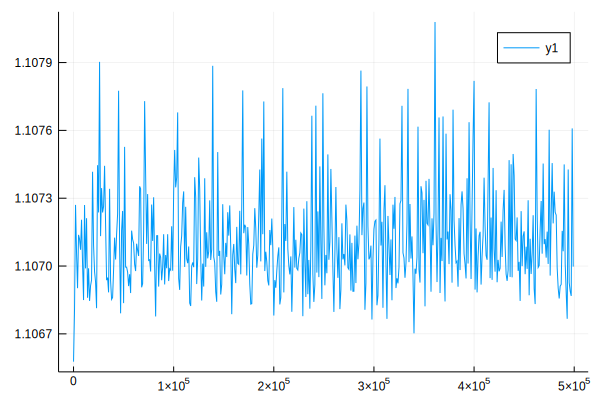

In [20]:
# Plot losses on whole dataset, first steps seem transient, ~10 secs
r = 1:1000:size(W,2)
@time plot(r, [loss(ARRAY(W[:,i]),atrn,ytrn) for i in r])

In [21]:
rr1,rr2 = rand(1:size(W,1)),rand(1:size(W,1))

(484, 186)

(rr1, rr2) = (rand(1:size(W, 1)), rand(1:size(W, 1))) = (402, 351)


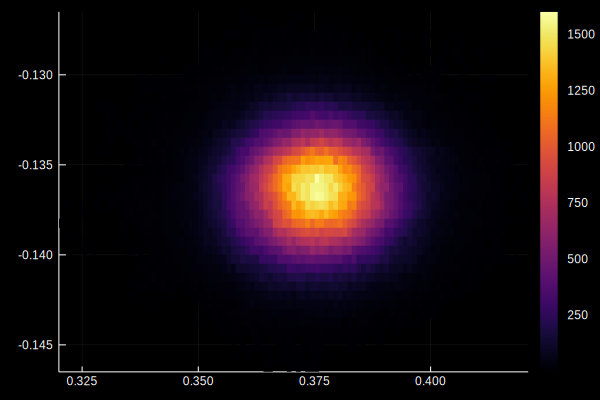

In [22]:
# Plot trajectory of two random dimensions
@show rr1,rr2 = rand(1:size(W,1)),rand(1:size(W,1))
if norm(W[rr1,:]) > 0 && norm(W[rr2,:]) > 0
    histogram2d(W[rr1,:],W[rr2,:],background_color="black")
end

In [23]:
# Minibatch training seems to converge to a slightly worse spot
w0 = Array(value(wmin))
μ = mean(W[:,2500:end],dims=2)
w1 = W[:,end]
@show norm(w0), norm(μ), norm(w0 - μ)
@show extrema(w0), extrema(μ), extrema(w0 - μ)
@show mean(abs.(w0 - μ) .> 0.01)
@show loss(w0,xtrn,ytrn)
@show loss(μ,xtrn,ytrn)
@show loss(w1,xtrn,ytrn)

(norm(w0), norm(μ), norm(w0 - μ)) = (7.852038561508006, 7.853574171255834, 0.0033902796201020872)
(extrema(w0), extrema(μ), extrema(w0 - μ)) = ((-1.106838542256809, 1.2638473534747794), (-1.106991644364908, 1.2637443369832964), (-0.0004726553825336599, 0.0005164803822507169))
mean(abs.(w0 - μ) .> 0.01) = 0.0
loss(w0, xtrn, ytrn) = 1.1063619979685433
loss(μ, xtrn, ytrn) = 1.1063620439715731
loss(w1, xtrn, ytrn) = 1.1067613079075058


1.1067613079075058

# Covariance of SGD trajectory around minimum

In [24]:
#Wstable = W[:,2500:end];  @show summary(Wstable)
Wstable = W
μ = mean(Wstable,dims=2); @show summary(μ)
Wzero = Wstable .- μ;     @show summary(Wzero)
Σ = (Wzero * Wzero') / size(Wzero,2)
@show summary(Σ)
@show norm(Σ)
@show extrema(Σ)
@show norm(diag(Σ));

summary(μ) = "490×1 Array{Float64,2}"
summary(Wzero) = "490×500000 Array{Float64,2}"
summary(Σ) = "490×490 Array{Float64,2}"
norm(Σ) = 0.002477300594211188
extrema(Σ) = (-4.565042382076289e-5, 0.00017278541241751085)
norm(diag(Σ)) = 0.0018329090667438025


In [25]:
# check for convergence
n2 = div(size(W,2),2)
w1 = W[:,1:n2]
w2 = W[:,1+n2:end]
w1 = w1 .- mean(w1,dims=2)
w2 = w2 .- mean(w2,dims=2)
Σ1 = (w1 * w1') / size(w1,2)
Σ2 = (w2 * w2') / size(w2,2);

In [26]:
# The variances (diagonal elements) converge
norm(diag(Σ1)),norm(diag(Σ2)),norm(diag(Σ1)-diag(Σ2)),norm(diag(Σ1)-diag(Σ2))/norm(diag(Σ2))

(0.0018315209494418829, 0.0018339471505326144, 4.9516134318636236e-5, 0.02699976076423782)

In [27]:
# The off diagonal elements are still not there
norm(Σ1),norm(Σ2),norm(Σ1-Σ2),norm(Σ1-Σ2)/norm(Σ2)

(0.0024999751865513536, 0.0025015318630770876, 0.0006894710864455951, 0.2756195500134424)

In [28]:
# Clean up
w1=0;w2=0;Σ1=0;Σ2=0;Knet.gc()

### Check Lyapunov equation

In [29]:
summary.((H,D,Σ))

("490×490 Array{Float64,2}", "490×490 Array{Float64,2}", "490×490 Array{Float64,2}")

In [30]:
a = H*Σ + Σ*H
b = (2/LR)*D
norm(a),norm(b),norm(a-b),norm(a-b)/norm(b)

(0.0006224469595961024, 0.0006189069211836367, 2.3569267899977238e-5, 0.03808208810284733)

## Covariance eigenspace

In [31]:
@time eigenΣ = eigen(Σ);

  0.058133 seconds (20 allocations: 5.673 MiB)


In [32]:
 ΛΣ = eigenΣ.values; O = eigenΣ.vectors;

In [33]:
ΛΣ # verify that the last eigenvectors are the largest ones

490-element Array{Float64,1}:
 -1.1143307626539568e-19
 -8.11957164739539e-20  
 -5.745141081308666e-20 
 -2.3513400004248393e-20
 -1.9632209749378273e-20
 -1.7984412547840987e-20
 -1.6850446687562232e-20
 -1.16547734405919e-20  
 -1.1444771419825148e-20
 -1.069171012464777e-20 
 -8.54049798358715e-21  
 -8.175052516095356e-21 
 -7.977936493751457e-21 
  ⋮                     
  0.0003337071450829933 
  0.0003374481419608647 
  0.00033949373563636867
  0.0003429242608395954 
  0.0003548584597908746 
  0.00035902742884247926
  0.0003678814702114372 
  0.0003883847064457276 
  0.0003969321693037856 
  0.000404406805205165  
  0.00042657308797368733
  0.0005349702261345944 

In [34]:
# transform the trajectory to the eigenbasis, keeping top Neig eigenvectors.
# Do the matrix mult in gpu in batches, since memory is not enough
# This is effectively the same as Weig=(O'*W)[end-Neig+1:end,:]

Neig=10 # number of top eigenvectors to keep
Or = O[:,end-Neig+1:end]; # reduced transformation matrix to the eigenbasis
ΛΣr = ΛΣ[end-Neig+1:end]
NB=div(div(CITER,CFREQ),10)
Weig = zeros(Neig,div(CITER,CFREQ))
for n=0:9
    Weig[:,NB*n+1:NB*(n+1)] = Array(ARRAY(Or')*ARRAY(W[:,NB*n+1:NB*(n+1)]));
end
#W=0;
Knet.gc() # to make space in gpu memory

In [35]:
## check Einstein relation in top Neig eigen-directions of Σ
aa = Or'*a*Or
bb = Or'*b*Or
norm(aa),norm(bb)/norm(aa),norm(aa-bb)/norm(aa)

(0.00040193656580632555, 0.9888981376390981, 0.01688691983621104)

In [36]:
# pick two eigen directions
Xid = Neig-2
Yid = Neig-3

Wx = Weig[Xid,:]
Wy = Weig[Yid,:]

#COV_ss = O'*Σ*O
#COV_xy_inv = inv(COV_ss[[Xid,Yid],[Xid,Yid]])
COV_xy_inv = Diagonal([1/ΛΣr[Xid],1/ΛΣr[Yid]]) + zeros(2,2)
μeig = Or'*μ
W0eig = Or'*w0;

In [37]:
myhplot = histogram2d(Wx,Wy
    ,bins=100
    ,aspect_ratio=1
    ,background_color="black"
);

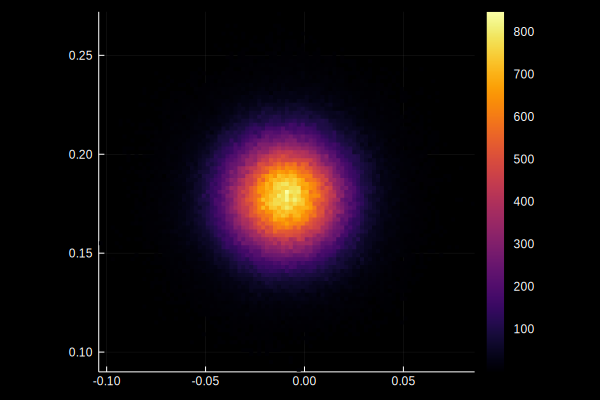

  0.371976 seconds (534.63 k allocations: 17.613 MiB, 2.78% gc time)


In [38]:
@time display(myhplot)

In [39]:
# Construct a grid enclosing the steady-state trajectory
minmaxdiff(t) = maximum(t)-minimum(t)

function makegrid(xvec,yvec,mean,xindex,yindex;Nx=50,Ny=50,zoom=0.35)
    Lx,Ly = minmaxdiff(xvec),minmaxdiff(yvec)
    xrange,yrange = zoom*Lx,zoom*Ly
    dx,dy = xrange/Nx,yrange/Ny
    x = collect(-xrange:dx:xrange) .+ mean[xindex]
    y = collect(-yrange:dy:yrange) .+ mean[yindex]

    Nw = length(mean) # number of dimensions
    # some mumbo-jumbo for calculating weights corresponding to grid points
    Identity = Diagonal(ones(Nw,Nw)); # unit matrix
    xmask = Identity[:,xindex];
    ymask = Identity[:,yindex];
    Imask = Identity - xmask*xmask' - ymask*ymask' # set two diagonal elements to zero
    return (x,y,Imask,xmask,ymask)
end

makegrid (generic function with 1 method)

In [40]:
(x,y,Imask,xmask,ymask) = makegrid(Wx,Wy,W0eig,Xid,Yid;Nx=12,Ny=12,zoom=0.5)
#(x,y,Imask,xmask,ymask) = makegrid(Wx,Wy,μeig,Xid,Yid;Nx=4,Ny=4);

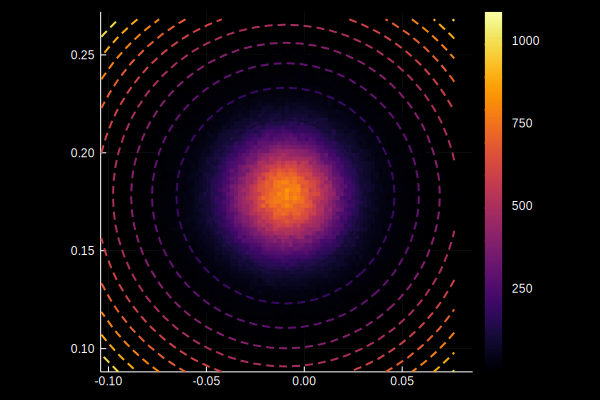

In [41]:
meanXY = W0eig[[Xid Yid]]
# Contours of the fit mv-Gaussian
ffit(s,t) = -(([s t]-meanXY)*COV_xy_inv*([s t]-meanXY)')[1]
Ffit(s,t) = 1e3*ffit(s,t)/ffit(x[end],y[end])
contour!(x,y,Ffit
    ,linestyle=:dash
    ,levels=10
    ,linewidth=2
)

In [42]:
# contours of loss
midx = div(length(x),2)
midy = div(length(y),2)
#fexp(s,t) = 1e5*(loss(Or*(Imask*W0eig + s*xmask + t*ymask),xtrn,ytrn) - loss(w0,xtrn,ytrn))
fexp(s,t) = 1e5*(loss(Or*(Imask*μeig + s*xmask + t*ymask),xtrn,ytrn) - loss(w0,xtrn,ytrn))
logfexpmidp1 = log(1+fexp(x[midx],y[midy]))
Flossxy(s,t) = 1e2*(log((1+fexp(s,t))) - logfexpmidp1)

Flossxy (generic function with 1 method)

## N,N-1

 69.088077 seconds (492.00 k allocations: 23.631 GiB, 5.84% gc time)


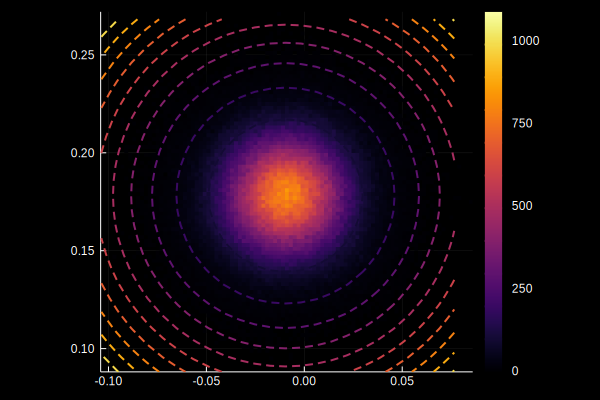

┌ Warning: Overwriting colorbar entry
└ @ Plots /home/ec2-user/.julia/packages/Plots/oiirH/src/backends/gr.jl:438


In [43]:
@time contour!(x,y,Flossxy
    ,levels=10
    ,linewidth=2
)

## Areal velocity

In [44]:
η = LR

0.01

In [45]:
# record the theoretical areal velocities
A = Or'*(η*H*Σ - D)*Or/η^2;

In [46]:
AA = Or'*(η/2)*(H*Σ - Σ*H)*Or/η^2;

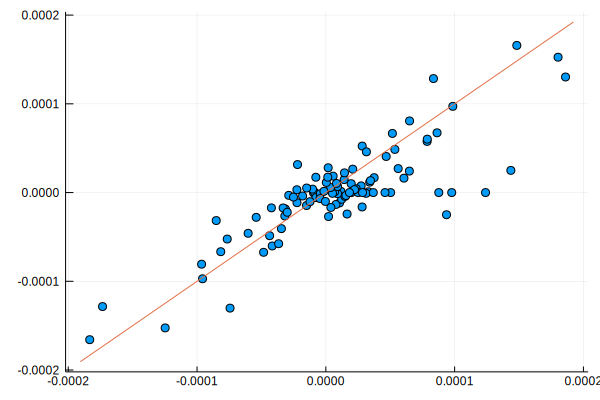

In [47]:
# This effectively shows the degree to which the Lyapunov equation is satisfied.
# Both A and AA theoretical values of the current, calculated through two different
# expressions (involving D,H,Σ above) related through the Lyapunov equation.

scatter(reshape(A,Neig^2,1),reshape(AA,Neig^2,1)
    ,leg=:false
#    ,xlim=[1e-8,1e-4]
#    ,ylim=[1e-8,1e-4]
#    ,xaxis=:log10
#    ,yaxis=:log10
)
g(x)=x
plot!(g)

In [49]:
# ## Collect trajectory data for areal velocity calculation
# ## Keeping 10^7 steps for 1000+ variables in memory or hard disk is a problem.
# ## Better keep track of top eigen-components (we already know them)


# # make space
# # H=0;D=0;Σ=0;W=0;Wstable=0;Knet.gc();Weig=0

# CITER = 10^7

# trajfile = "mnist7x7_traj_eig$Neig-$LAMBDA-$LR-$BATCHSIZE-$CITER.jld2"
# if !isfile(trajfile)
#     Knet.gc()
#     w = Param(ARRAY(value(wmin)))
#     data = MB(xtrn,ytrn,BATCHSIZE)
#     d = take(data,CITER)
#     Weig = ARRAY(zeros(eltype(w),Neig,CITER))
#     f(x,y) = loss(w,x,y)
#     i = 0
#     for t in progress(sgd(f,d; lr=LR))
#         i += 1
#         Weig[:,i] = ARRAY(O[:,Nweights-Neig+1:Nweights]')*vec(w)
#     end
#     Knet.save(trajfile,"Weig",Weig)
# else
#     Weig = Knet.load(trajfile,"Weig")
# end
# summary(Weig)

In [50]:
function arealvelo_trans(traj,x,y,center)
    N = length(traj[:,1])
    Area=zeros(N);
    Areasum=zeros(N);
    rad=0;
    for n=2:N
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[n-1,x]-center[x],traj[n-1,y]-center[y],0]
        v2=[traj[n,x]-center[x],traj[n,y]-center[y],0]
        rad += norm(v2) # mean radius of the trajectory - used for normalization
        Area[n] = cross(v1,v2)[3]/2
        Areasum[n] = Areasum[n-1]+Area[n]
#        Areasum[n-1] /= n-2
    end
#    Areasum[N] /= N-1    
    return Areasum,rad/(N-1)
end

arealvelo_trans (generic function with 1 method)

In [51]:
rad = zeros(Neig,Neig); # mean radius of w projections for each eigenvector pair

In [52]:
np = length(Weig[1,:]) # length of the trajectory
nskip = div(np,1000) # pick sampling rate to plot with 1000 points

500

In [53]:
@time area_vs_t,rad[Xid,Yid] = arealvelo_trans(Array(Weig)',Xid,Yid,W0eig);

  1.957864 seconds (7.72 M allocations: 358.267 MiB, 16.00% gc time)


In [54]:
orbit_area = π*rad[Xid,Yid]^2

0.0019747391821684224

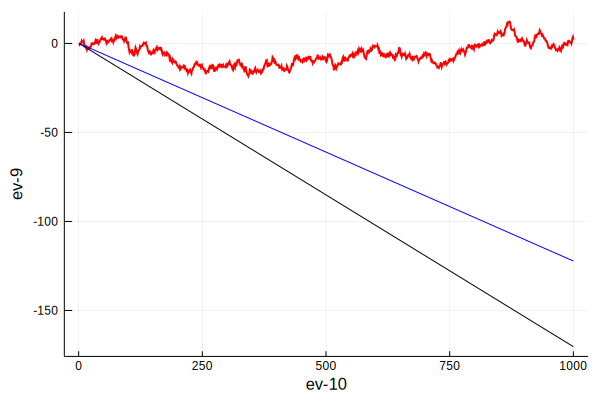

In [55]:
Xid,Yid=Neig,Neig-1
x = collect(1:nskip:np)
plot(area_vs_t[1:nskip:np]/orbit_area
    ,leg=false
    ,linewidth=2,linecolor="red"
    ,xlabel="ev-$Xid",ylabel="ev-$Yid"
    ) # plot number of turns vs step
plot!(η^2*(AA[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="black")
plot!(η^2*(A[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="blue")

  1.791365 seconds (7.50 M allocations: 347.137 MiB, 17.34% gc time)


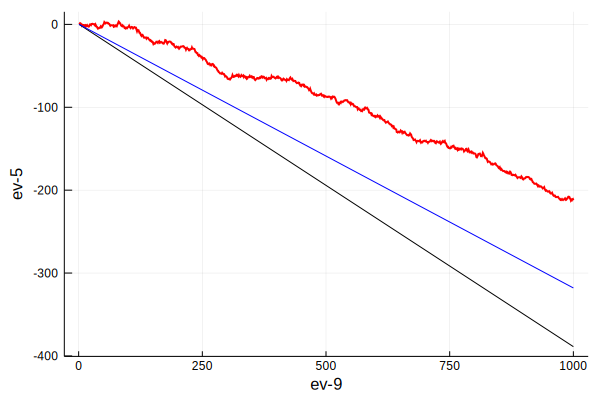

In [56]:
Xid,Yid=Neig-1,Neig-5
@time area_vs_t,rad[Xid,Yid] = arealvelo_trans(Array(Weig)',Xid,Yid,W0eig);
orbit_area = π*rad[Xid,Yid]^2
x = collect(1:nskip:np)
plot(area_vs_t[1:nskip:np]/orbit_area
    ,leg=false
    ,linewidth=2,linecolor="red"
    ,xlabel="ev-$Xid",ylabel="ev-$Yid"
    ) # plot number of turns vs step
plot!(η^2*(AA[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="black")
plot!(η^2*(A[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="blue")

  1.802855 seconds (7.50 M allocations: 347.137 MiB, 17.67% gc time)


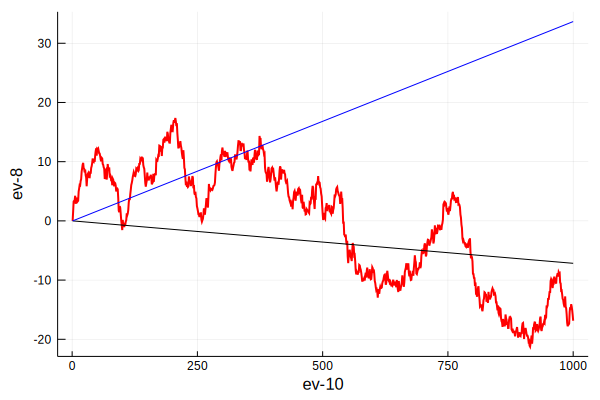

In [57]:
Xid,Yid=Neig,Neig-2
@time area_vs_t,rad[Xid,Yid] = arealvelo_trans(Array(Weig)',Xid,Yid,W0eig);
orbit_area = π*rad[Xid,Yid]^2
x = collect(1:nskip:np)
plot(area_vs_t[1:nskip:np]/orbit_area
    ,leg=false
    ,linewidth=2,linecolor="red"
    ,xlabel="ev-$Xid",ylabel="ev-$Yid"
    ) # plot number of turns vs step
plot!(η^2*(AA[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="black")
plot!(η^2*(A[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="blue")

  1.778888 seconds (7.50 M allocations: 347.137 MiB, 16.89% gc time)


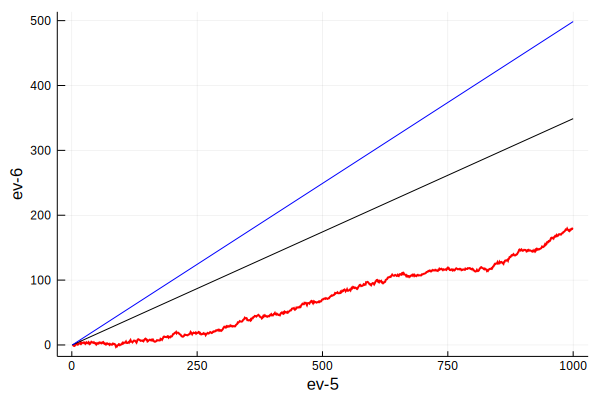

In [58]:
Xid,Yid=Neig-5,Neig-4
@time area_vs_t,rad[Xid,Yid] = arealvelo_trans(Array(Weig)',Xid,Yid,W0eig);
orbit_area = π*rad[Xid,Yid]^2
x = collect(1:nskip:np)
plot(area_vs_t[1:nskip:np]/orbit_area
    ,leg=false
    ,linewidth=2,linecolor="red"
    ,xlabel="ev-$Xid",ylabel="ev-$Yid"
    ) # plot number of turns vs step
plot!(η^2*(AA[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="black")
plot!(η^2*(A[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="blue")

  1.781348 seconds (7.50 M allocations: 347.137 MiB, 16.96% gc time)


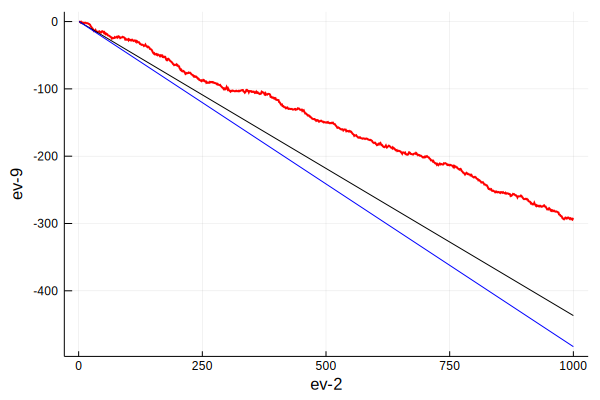

In [59]:
Xid,Yid=Neig-8,Neig-1
@time area_vs_t,rad[Xid,Yid] = arealvelo_trans(Array(Weig)',Xid,Yid,W0eig);
orbit_area = π*rad[Xid,Yid]^2
x = collect(1:nskip:np)
plot(area_vs_t[1:nskip:np]/orbit_area
    ,leg=false
    ,linewidth=2,linecolor="red"
    ,xlabel="ev-$Xid",ylabel="ev-$Yid"
    ) # plot number of turns vs step
plot!(η^2*(AA[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="black")
plot!(η^2*(A[Xid,Yid]/orbit_area)*x*CFREQ,linecolor="blue")

In [60]:
function arealvelocity(traj,x,y,center)
    N = length(traj[:,1])
    Area=zeros(N-1);
    Areasum=0
    for n=2:N
        # construct vectors connecting the trajectory points to the center (mean)
        v1=[traj[n-1,x]-center[x],traj[n-1,y]-center[y],0]
        v2=[traj[n,x]-center[x],traj[n,y]-center[y],0]
        Areasum += cross(v1,v2)[3] # this is twice the area of the triangle
    end
    return Areasum/(2*N)
end

av = zeros(Neig,Neig)
for i in progress(1:Neig-1)
    for j = i+1:Neig
        av[i,j] = arealvelocity(Array(Weig)',i,j,W0eig)
        av[j,i] = -av[i,j]
    end
end

9.00e+00  100.00%┣███████████████████████████████████┫ 9/9 [01:16/01:16, 8.44s/i]


In [61]:
B = av#/η^2

10×10 Array{Float64,2}:
  0.0         -1.25529e-7  -1.32203e-8  …   2.46587e-7   8.80855e-8
  1.25529e-7   0.0          2.58448e-7     -1.11654e-6  -1.75451e-7
  1.32203e-8  -2.58448e-7   0.0             2.29333e-7   1.19695e-7
 -7.12181e-8   6.16483e-8   3.47392e-9      1.85296e-7   2.83928e-7
 -3.55372e-7   8.13099e-7  -9.31787e-8      8.35194e-7  -1.46392e-7
 -1.35404e-7   9.14158e-7  -3.41005e-7  …   4.66514e-7   2.24566e-8
 -2.09546e-7   6.18191e-7  -5.44281e-7     -1.75502e-7  -3.54938e-8
 -1.22553e-7   3.2714e-7    7.12936e-7      1.59573e-8   7.091e-8  
 -2.46587e-7   1.11654e-6  -2.29333e-7      0.0          5.56722e-7
 -8.80855e-8   1.75451e-7  -1.19695e-7     -5.56722e-7   0.0       

In [62]:
size(B)

(10, 10)

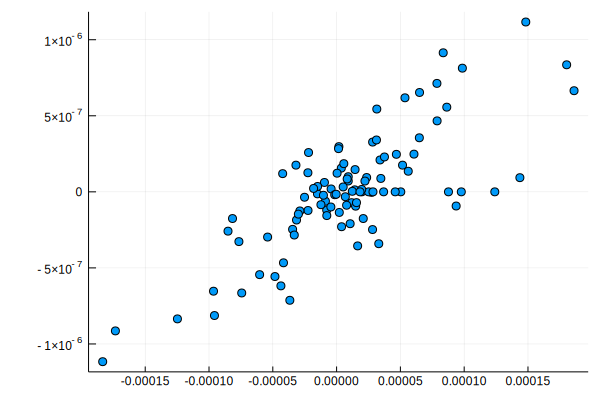

In [63]:
# Compare the computed current with the analytical expression (η*H*Σ - D)/η²
scatter(reshape(A,Neig^2,1),reshape(B,Neig^2,1)
    ,leg=:false
#    ,xlim=[1e-8,1e-4]
#    ,ylim=[1e-8,1e-4]
#    ,xaxis=:log10
#    ,yaxis=:log10
)
# g(x)=x
# plot!(g)

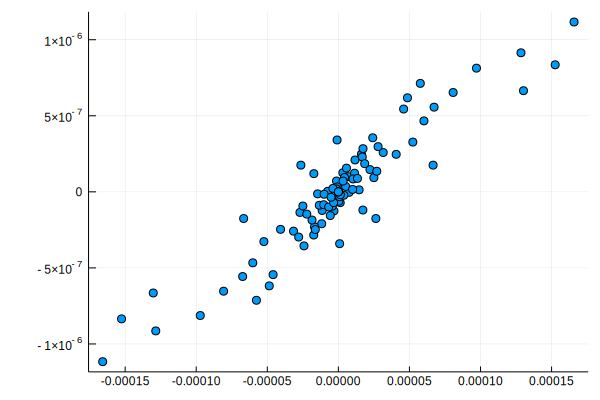

In [64]:
# Compare the computed current with the analytical expression (H*Σ - Σ*H)/η²

scatter(reshape(AA,Neig^2,1),reshape(B,Neig^2,1)
    ,leg=:false
#    ,xlim=[1e-8,1e-4]
#    ,ylim=[1e-8,1e-4]
#    ,xaxis=:log10
#    ,yaxis=:log10
)
# g(x)=x
# plot!(g)

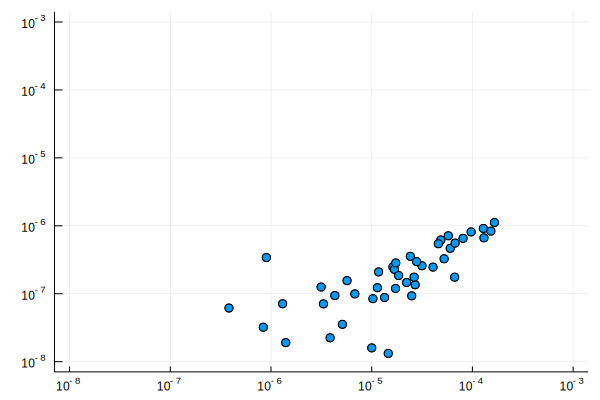

In [70]:
epsi=1e-20
scatter(abs.(reshape(AA,Neig^2,1)).+epsi,abs.(reshape(B,Neig^2,1).+epsi)
    ,leg=:false
    ,xlim=[1e-8,1e-3]
    ,ylim=[1e-8,1e-3]
    ,xaxis=:log10
    ,yaxis=:log10
)

In [65]:
findmax(A)

(0.0001861126367833959, CartesianIndex(5, 6))

In [66]:
findmax(AA)

(0.00016580659012762882, CartesianIndex(9, 2))